# [개념정리]

## 09. 분류 실습 
- 데이터 전처리 : XGBoost 사용
- 편차가 심할 때는 다른 값으로 대체하기
- 학습과 성능 평가를 위해서는 학습 데이터 세트와 테스트 데이터 세트를 분리하기

### XGBoost 모델 학습과 하이퍼 파라미터 튜닝 
- XGBoost가 GBM보다는 빠르나, 수행 시간이 상당히 요구됨.
- 앙상블 계열 알고리즘에서 하이퍼 파라미터 튜닝으로 성능 수치 개선이 급격히 되는 경우 많지 않음

### LightGBM 모델 학습과 하이퍼 파라미터 튜닝 
- XGBoost보다 학습에 걸리는 시간이 더 단축됨
- fmin() : 최적의 파라미터 도출

## 10. 분류 실습 - 캐글 신용카드 사기 검출 

### 언더샘플링과 오버샘플링의 이해 
- 언더샘플링 : 많은 레이블을 가진 데이터 세트를 적은 레이블을 가진 데이터 세트 수준으로 감소
- 오버샘플링 : 적은 레이블을 가진 데이터 세트를 많은 레이블을 가진 데이터 세트 수준으로 증식

### 이상치 데이터 제거 후 모델 학습/예측/평가
- 이상치 데이터 : 전체 데이터 패턴에서 벗어난 이상 값을 가진 데이터 [outlier]
- 사분위 값의 편차를 이용해 찾는 방법이 있음 : 이를 통해 최댓값과 최솟값을 정한 뒤 최댓값을 초과하거나 최솟값에 미달하는 데이터를 이상치로 간주함

### SMOTE 오버 샘플링 적용 후 모델 학습/예측/평가
- 반드시 학습 데이터 세트만 오버 샘플링 해야 함.

In [76]:
pip install --upgrade xgboost

Note: you may need to restart the kernel to use updated packages.


In [2]:
import xgboost
print(xgboost.__version__)

3.0.0


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import warnings

warnings.filterwarnings('ignore')
cust_df = pd.read_csv('/Users/josoobin/downloads/train_santander.csv',encoding='latin-1')
print('dataset shape:', cust_df.shape)
cust_df.head(3)

dataset shape: (76020, 371)


,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.17,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.03,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.77,0


In [4]:
cust_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76020 entries, 0 to 76019
Columns: 371 entries, ID to TARGET
dtypes: float64(111), int64(260)
memory usage: 215.2 MB


In [5]:
print(cust_df['TARGET'].value_counts())
unsatisfied_cnt = cust_df[cust_df['TARGET'] == 1].TARGET.count()
total_cnt = cust_df.TARGET.count()
print('unsatisfied 비율은 {0:.4f}'.format((unsatisfied_cnt/total_cnt)))

TARGET
0    73012
1     3008
Name: count, dtype: int64
unsatisfied 비율은 0.0396


In [6]:
cust_df.describe()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
count,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,...,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,76020.000000
mean,75964.050723,-1523.199277,33.212865,86.208265,72.363067,119.529632,3.559130,6.472698,0.412946,0.567352,...,7.935824,1.365146,12.215580,8.784074,31.505324,1.858575,76.026165,56.614351,1.172358e+05,0.039569
std,43781.947379,39033.462364,12.956486,1614.757313,339.315831,546.266294,93.155749,153.737066,30.604864,36.513513,...,455.887218,113.959637,783.207399,538.439211,2013.125393,147.786584,4040.337842,2852.579397,1.826646e+05,0.194945
min,1.000000,-999999.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.163750e+03,0.000000
25%,38104.750000,2.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.787061e+04,0.000000
50%,76043.000000,2.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.064092e+05,0.000000
75%,113748.750000,2.000000,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.187563e+05,0.000000
max,151838.000000,238.000000,105.000000,210000.000000,12888.030000,21024.810000,8237.820000,11073.570000,6600.000000,6600.000000,...,50003.880000,20385.720000,138831.630000,91778.730000,438329.220000,24650.010000,681462.900000,397884.300000,2.203474e+07,1.000000


In [7]:
cust_df['var3'].replace(-99999,2,inplace=True)
cust_df.drop('ID',axis=1,inplace=True)

# 피처 세트와 레이블 세트 분리, 레이블 칼럼은 DataFrame의 맨 마지막에 위치해 칼럼 위치 -1로 분리
X_features = cust_df.iloc[:, :-1]
y_labels = cust_df.iloc[:, -1]
print('피처 데이터 shape:{0}'.format(X_features.shape))

피처 데이터 shape:(76020, 369)


In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_features, y_labels,
                                                    test_size=0.2,random_state=0)
train_cnt = y_train.count()
test_cnt = y_test.count()
print('학습 세트 Shape:{0}, 테스트 세트 Shape:{1}'.format(X_train.shape, X_test.shape))

print('학습 세트 레이블 값 분포 비율')
print(y_train.value_counts()/train_cnt)
print('\n 테스트 세트 레이블 값 분포 비율')
print(y_test.value_counts()/test_cnt)

학습 세트 Shape:(60816, 369), 테스트 세트 Shape:(15204, 369)
학습 세트 레이블 값 분포 비율
TARGET
0    0.960964
1    0.039036
Name: count, dtype: float64

 테스트 세트 레이블 값 분포 비율
TARGET
0    0.9583
1    0.0417
Name: count, dtype: float64


In [9]:
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=0)

In [10]:
import xgboost as xgb
from sklearn.metrics import roc_auc_score

# DMatrix로 변환
dtrain = xgb.DMatrix(X_tr, label=y_tr)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test)

# 파라미터 정의
params = {
    'objective': 'binary:logistic',
    'learning_rate': 0.05,
    'eval_metric': 'auc',
    'seed': 156
}

# 학습
xgb_model = xgb.train(params=params,
                      dtrain=dtrain,
                      num_boost_round=100,  # early_stopping_rounds 없음
                      evals=[(dval, 'validation')],
                      verbose_eval=False)

# 예측 및 평가
y_proba = xgb_model.predict(dtest)
roc_score = roc_auc_score(y_test, y_proba)
print('ROC AUC: {:.4f}'.format(roc_score))

ROC AUC: 0.8407


In [11]:
from hyperopt import hp

# max_depth는 5에서 15까지 1 간격으로, min_child_weight는 1에서 6까지 1 간격으로 
# colsample_bytreesms 0.5에서 0.95 사이, learning_rate는 0.01에서 0.2 사이 정규 분포된 값으로 검색.
xgb_search_space = {'max_depth' : hp.quniform('max_depth',5,15,1),
                    'min_child_weight' : hp.quniform('min_child_weight',1,6,1),
                    'colsample_bytree' :hp.quniform('colsample_bytree',0.5,0.95),
                    'learning_rate' : hp.quniform('learning_rate',0.01,0.2)}

In [12]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
import xgboost as xgb
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK

# (1) 하이퍼파라미터 탐색 공간 정의
xgb_search_space = {
    'max_depth': hp.quniform('max_depth', 5, 15, 1),
    'min_child_weight': hp.quniform('min_child_weight', 1, 7, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 0.95),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2)
}

# (2) 목적 함수 정의
def objective_func(search_space):
    roc_auc_list = []

    # 3-fold 교차검증
    kf = KFold(n_splits=3, shuffle=True, random_state=42)
    for train_idx, val_idx in kf.split(X_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        # DMatrix 생성
        dtrain = xgb.DMatrix(X_tr, label=y_tr)
        dval = xgb.DMatrix(X_val, label=y_val)

        # 하이퍼파라미터 설정
        params = {
            'objective': 'binary:logistic',
            'learning_rate': search_space['learning_rate'],
            'max_depth': int(search_space['max_depth']),
            'min_child_weight': int(search_space['min_child_weight']),
            'colsample_bytree': search_space['colsample_bytree'],
            'eval_metric': 'auc',
            'seed': 42
        }

        # 모델 학습
        model = xgb.train(params=params,
                          dtrain=dtrain,
                          num_boost_round=100,
                          evals=[(dval, 'eval')],
                          verbose_eval=False)

        # 평가
        dval_pred = model.predict(dval)
        roc_score = roc_auc_score(y_val, dval_pred)
        roc_auc_list.append(roc_score)

    # 목적 함수: -평균 ROC AUC
    return {'loss': -np.mean(roc_auc_list), 'status': STATUS_OK}

In [13]:
from hyperopt import fmin, tpe, Trials

trials = Trials()

best = fmin(fn=objective_func,
            space=xgb_search_space,
            algo=tpe.suggest,
            max_evals=50,
            trials=trials,
            rstate=np.random.default_rng(seed=30))

print('best : ', best)

100%|████████| 50/50 [02:29<00:00,  2.98s/trial, best loss: -0.8388783120532263]
best :  {'colsample_bytree': 0.5973244662235043, 'learning_rate': 0.03958773322267459, 'max_depth': 5.0, 'min_child_weight': 4.0}


In [14]:
import xgboost as xgb
from sklearn.metrics import roc_auc_score

# DMatrix 변환
dtrain = xgb.DMatrix(X_tr, label=y_tr)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test)

# 최적 하이퍼파라미터 적용
params = {
    'objective': 'binary:logistic',
    'learning_rate': round(best['learning_rate'], 5),
    'max_depth': int(best['max_depth']),
    'min_child_weight': int(best['min_child_weight']),
    'colsample_bytree': round(best['colsample_bytree'], 5),
    'eval_metric': 'auc',
    'seed': 42
}

# 모델 학습
model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=500,
    evals=[(dval, 'eval')],
    verbose_eval=False
)

# 테스트 데이터 ROC-AUC 평가
y_proba = model.predict(dtest)
roc_auc = roc_auc_score(y_test, y_proba)
print('ROC AUC: {:.4f}'.format(roc_auc))

ROC AUC: 0.8445


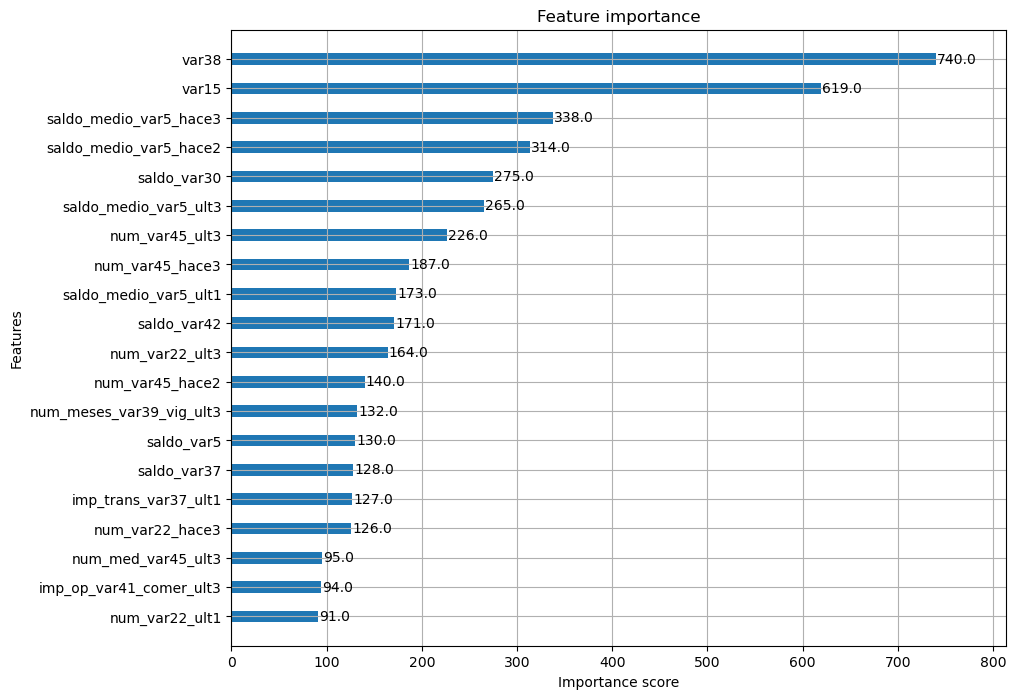

In [15]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax =plt.subplots(1,1,figsize=(10,8))
plot_importance(model,ax=ax,max_num_features=20,height=0.4)
plt.show()

In [16]:
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score 

# LightGBM 모델 정의 (early_stopping 없이 고정된 n_estimators 사용)
lgbm_clf = LGBMClassifier(
    n_estimators=300,     # 튜닝해서 고정된 트리 수
    learning_rate=0.05,
    max_depth=6,
    num_leaves=32,
    random_state=42
)

# 학습 (eval_metric만 사용 가능)
lgbm_clf.fit(
    X_tr, y_tr,
    eval_set=[(X_val, y_val)],
    eval_metric='auc',
)

# 예측 및 ROC-AUC 평가
y_proba = lgbm_clf.predict_proba(X_test)[:, 1]
roc_score = roc_auc_score(y_test, y_proba)
print("ROC AUC: {:.4f}".format(roc_score))

[LightGBM] [Info] Number of positive: 1658, number of negative: 40913
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009822 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13309
[LightGBM] [Info] Number of data points in the train set: 42571, number of used features: 242
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.038947 -> initscore=-3.205836
[LightGBM] [Info] Start training from score -3.205836
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

In [17]:
lgbm_search_space = {'num_leaves': hp.quniform('num_leaves',32,64,1),
                     'max_depth' : hp.quniform('max_depth',100,160,1),
                     'min_child_samples' : hp.quniform('min_child_samples',60,100,1),
                     'subsample' : hp.quniform('subsample',0.7,1),
                     'learning_rate' : hp.quniform('learning_rate',0.01,0.2)
                    }

In [18]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from lightgbm import LGBMClassifier
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK

# 1. 탐색 공간 정의
lgbm_search_space = {
    'num_leaves': hp.quniform('num_leaves', 32, 64, 1),
    'max_depth': hp.quniform('max_depth', 100, 160, 1),
    'min_child_samples': hp.quniform('min_child_samples', 60, 100, 1),
    'subsample': hp.uniform('subsample', 0.7, 1.0),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2)
}

#  2. 목적 함수 정의
def objective_func(params):
    # 하이퍼파라미터 형 변환
    params = {
        'num_leaves': int(params['num_leaves']),
        'max_depth': int(params['max_depth']),
        'min_child_samples': int(params['min_child_samples']),
        'subsample': params['subsample'],
        'learning_rate': params['learning_rate'],
        'n_estimators': 100,
        'random_state': 42
    }

    roc_auc_list = []
    kf = KFold(n_splits=3, shuffle=True, random_state=42)

    for tr_idx, val_idx in kf.split(X_train):
        X_tr, X_val = X_train.iloc[tr_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[tr_idx], y_train.iloc[val_idx]

        # 모델 학습 (early_stopping 없이 고정된 n_estimators)
        model = LGBMClassifier(**params)
        model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], eval_metric='auc')

        # 평가
        y_pred = model.predict_proba(X_val)[:, 1]
        roc_auc = roc_auc_score(y_val, y_pred)
        roc_auc_list.append(roc_auc)

    return {'loss': -np.mean(roc_auc_list), 'status': STATUS_OK}

In [19]:
from hyperopt import fmin, tpe, Trials

trials = Trials()

best = fmin(
    fn=objective_func,
    space=lgbm_search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=trials,
    rstate=np.random.default_rng(30)
)

print('best : ', best)

[LightGBM] [Info] Number of positive: 1601, number of negative: 38943           
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009170 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12869                                              
[LightGBM] [Info] Number of data points in the train set: 40544, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.039488 -> initscore=-3.191471 
[LightGBM] [Info] Start training from score -3.191471                           
[LightGBM] [Info] Number of positive: 1586, number of negative: 38958           
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008046 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12853               

In [20]:
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score

# 튜닝된 best 값 기반 모델 정의
lgbm_clf = LGBMClassifier(
    n_estimators=500,
    num_leaves=int(best['num_leaves']),
    max_depth=int(best['max_depth']),
    min_child_samples=int(best['min_child_samples']),
    subsample=best['subsample'],
    learning_rate=best['learning_rate'],
    random_state=42
)

# 학습 (early_stopping 제거, eval_metric은 유지 가능)
lgbm_clf.fit(
    X_tr, y_tr,
    eval_set=[(X_val, y_val)],
    eval_metric='auc'
)

# 평가
y_proba = lgbm_clf.predict_proba(X_test)[:, 1]
lgbm_roc_score = roc_auc_score(y_test, y_proba)
print("ROC AUC: {:.4f}".format(lgbm_roc_score))

[LightGBM] [Info] Number of positive: 1658, number of negative: 40913
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005489 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12899
[LightGBM] [Info] Number of data points in the train set: 42571, number of used features: 192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.038947 -> initscore=-3.205836
[LightGBM] [Info] Start training from score -3.205836
ROC AUC: 0.8334


분류 실습 - 캐글 신용카드 사기 검출

In [22]:
conda install -c conda-forge imbalanced-learn

Channels:
 - conda-forge
 - defaults
Platform: osx-arm64
Solving environment: done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings('ignore')
%matplotlib inline

card_df = pd.read_csv('/Users/josoobin/downloads/creditcard.csv')
card_df.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


In [24]:
from sklearn.model_selection import train_test_split

# 인자로부터 입력받은 DataFrame을 복사한 뒤 Time 칼럼만 삭제하고 복사된 DataFrame 반환
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    df_copy.drop('Time', axis=1, inplace=True)
    return df_copy

In [25]:
def get_train_test_dataset(df=None):
    df_copy = get_preprocessed_df(df)
    X_features = df_copy.iloc[:,:-1]
    y_target = df_copy.iloc[:,-1]
    X_train, X_test, y_train, y_test = \
    train_test_split(X_features, y_target, test_size=0.3, random_state=0, stratify=y_target)
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

In [26]:
print('학습 데이터 레이블 값 비율')
print(y_train.value_counts()/y_train.shape[0]*100)
print('테스트 데이터 레이블 값 비율')
print(y_test.value_counts()/y_test.shape[0]*100)

학습 데이터 레이블 값 비율
Class
0    99.827451
1     0.172549
Name: count, dtype: float64
테스트 데이터 레이블 값 비율
Class
0    99.826785
1     0.173215
Name: count, dtype: float64


In [29]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    # ROC-AUC 추가
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC: {4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [31]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(max_iter=1000)
lr_clf.fit(X_train, y_train)
lr_pred = lr_clf.predict(X_test)
lr_pred_proba = lr_clf.predict_proba(X_test)[:,1]

# 3장에서 사용한 get_clf_eval()함수를 이용해 평가 수행.
get_clf_eval(y_test, lr_pred, lr_pred_proba)

오차 행렬
[[85282    13]
 [   57    91]]
정확도: 0.9992, 정밀도: 0.8750, 재현율: 0.6149,    F1: 0.7222, AUC: 0.9735


In [39]:
def get_model_train_eval(model,ftr_train=None, ftr_test=None, tgt_train=None, tgt_test=None):
    model.fit(ftr_train, tgt_train)
    pred = model.predict(ftr_test)
    pred_proba = model.predict_proba(ftr_test)[:,1]
    get_clf_eval(tgt_test, pred, pred_proba)

In [41]:
from lightgbm import LGBMClassifier 

lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

[LightGBM] [Info] Number of positive: 344, number of negative: 199020
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007104 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 199364, number of used features: 29
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

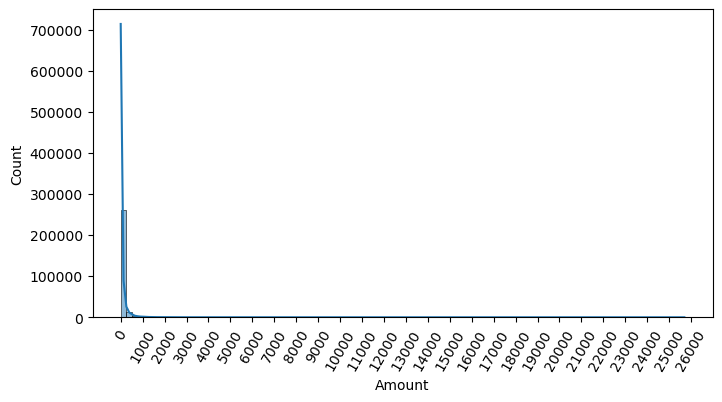

In [45]:
import seaborn as sns

plt.figure(figsize=(8,4))
plt.xticks(range(0,30000,1000),rotation=60)
sns.histplot(card_df['Amount'], bins=100, kde=True)
plt.show()

In [47]:
from sklearn.preprocessing import StandardScaler

def get_preprocessed_df(df=None):
    df_copy=df.copy()
    scaler=StandardScaler()
    amount_n = scaler.fit_transform(df_copy['Amount'].values.reshape(-1,1))
    df_copy.insert(0,'Amount_Scaled',amount_n)
    df_copy.drop(['Time','Amount'],axis=1,inplace=True)
    return df_copy

In [49]:
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

lr_clf = LogisticRegression(max_iter=1000)
get_model_train_eval(lr_clf,ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

print('### 로지스틱 회귀 예측 성능 ###')
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

오차 행렬
[[85281    14]
 [   55    93]]
정확도: 0.9992, 정밀도: 0.8692, 재현율: 0.6284,    F1: 0.7294, AUC: 0.9706
### 로지스틱 회귀 예측 성능 ###
[LightGBM] [Info] Number of positive: 344, number of negative: 199020
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007305 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 199364, number of used features: 29
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

In [51]:
def get_preprocessed_Df(df=None):
    df_copy=df.copy()
    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0,'Amount_Scaled',amount_n)
    df_copy.drop(['Time','Amount'], axis=1, inplace=True)
    return df_copy

In [53]:
X_train, X_test, y_train ,y_test = get_train_test_dataset(card_df)

print('### 로지스틱 회귀 예측 성능 ###')
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

print('### LightGBM 예측 성능 ###')
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[85281    14]
 [   55    93]]
정확도: 0.9992, 정밀도: 0.8692, 재현율: 0.6284,    F1: 0.7294, AUC: 0.9706
### LightGBM 예측 성능 ###
[LightGBM] [Info] Number of positive: 344, number of negative: 199020
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006225 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 199364, number of used features: 29
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

<Axes: >

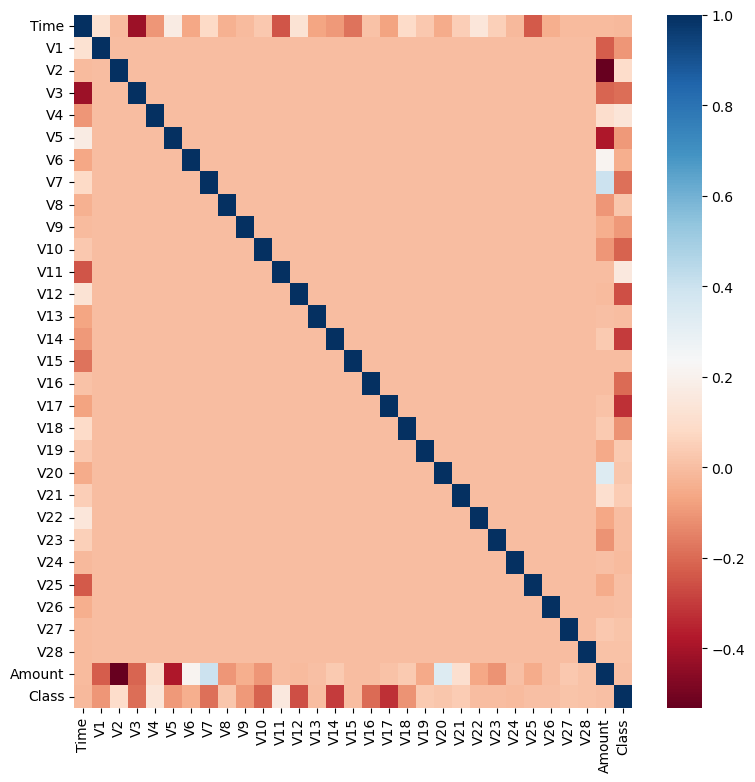

In [55]:
import seaborn as sns

plt.figure(figsize=(9,9))
corr = card_df.corr()
sns.heatmap(corr, cmap='RdBu')

In [57]:
import numpy as np

def get_outlier(df=None, column=None, weight=1.5):
    fraud = df[df['Class'] == 1][column]
    quantile_25 = np.percentile(fraud.values, 25)
    quantile_75 = np.percentile(fraud.values, 75)

    iqr = quantile_75 - quantile_25
    iqr_weight = iqr * weight
    lowest_val = quantile_25 - iqr_weight
    highest_val = quantile_75 + iqr_weight
    outlier_index = fraud[(fraud < lowest_val) | (fraud > highest_val)].index
    return outlier_index

In [59]:
outlier_index = get_outlier(df=card_df, column='V14', weight=1.5)
print('이상치 데이터 인덱스 : ', outlier_index)

이상치 데이터 인덱스 :  Index([8296, 8615, 9035, 9252], dtype='int64')


In [61]:
def get_preprocessed_df(df=None):
    df_copy=df.copy()
    scaler=StandardScaler()
    amount_n = scaler.fit_transform(df_copy['Amount'].values.reshape(-1,1))
    df_copy.insert(0,'Amount_Scaled',amount_n)
    df_copy.drop(['Time','Amount'],axis=1,inplace=True)
    outlier_index = get_outlier(df=df_copy, column='V14', weight=1.5)
    df_copy.drop(outlier_index, axis=0, inplace=True)
    return df_copy

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)
print('### 로지스틱 회귀 예측 성능 ###')
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

print('### LightGBM 예측 성능 ###')
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[85279    16]
 [   49    97]]
정확도: 0.9992, 정밀도: 0.8584, 재현율: 0.6644,    F1: 0.7490, AUC: 0.9759
### LightGBM 예측 성능 ###
[LightGBM] [Info] Number of positive: 342, number of negative: 199020
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009428 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 199362, number of used features: 29
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

In [65]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=0)
X_train_over, y_train_over = smote.fit_resample(X_train, y_train)
print ('SMOTE 적용 전 학습용 피처 /레이블 데이터 세트:',  X_train.shape, y_train.shape)
print ('SMOTE 적용 후 학습용 피처/레이블 데이터 세트:', X_train_over.shape, y_train_over. shape)
print('SMOTE 적용 후 레이블 값 분포: \n', pd.Series(y_train_over).value_counts())

SMOTE 적용 전 학습용 피처 /레이블 데이터 세트: (199362, 29) (199362,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트: (398040, 29) (398040,)
SMOTE 적용 후 레이블 값 분포: 
 Class
0    199020
1    199020
Name: count, dtype: int64


In [69]:
lr_clf = LogisticRegression(max_iter=1000)
get_model_train_eval(lr_clf, ftr_train=X_train_over, ftr_test=X_test, tgt_train=y_train_over, tgt_test=y_test)

오차 행렬
[[82940  2355]
 [   11   135]]
정확도: 0.9723, 정밀도: 0.0542, 재현율: 0.9247,    F1: 0.1024, AUC: 0.9743


In [121]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

def precision_recall_curve_plot(y_test, pred_proba_c1): 
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)
    # 소축을 threshlold값으로, 우축은 정밀도, 재현율 값으로 각각 Plot 수행
    plt.figure(figsize=(8, 6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label = 'precision')
    plt.plot(thresholds, recalls[0:threshold_boundary], label = 'recall')

    # threshold 값 X 축의 Scale을 0.1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    # x축, y축 label과 legend, 그리고 grid 설정
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend(); plt.grid()
    plt.show()

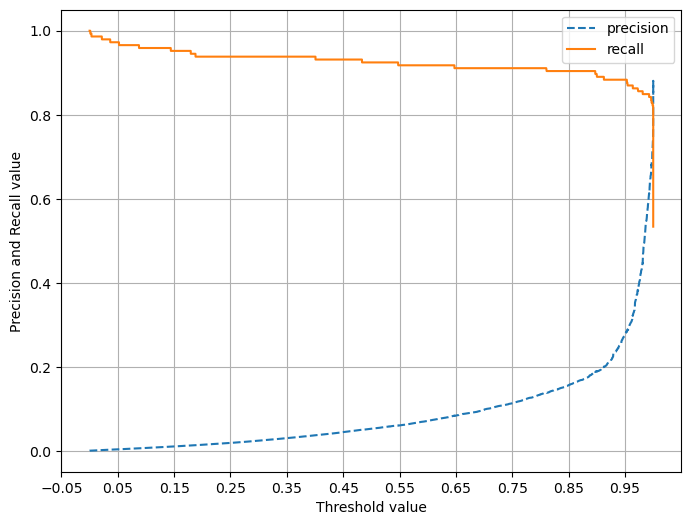

In [123]:
precision_recall_curve_plot(y_test, lr_clf.predict_proba(X_test)[:,1])

In [73]:
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train_over, ftr_test=X_test,
                     tgt_train=y_train_over, tgt_test=y_test)

[LightGBM] [Info] Number of positive: 199020, number of negative: 199020
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013483 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 398040, number of used features: 29
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split